# Set-up & Helper Functions

In [13]:
import os
import gym
import slimevolleygym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from stable_baselines.ppo1 import PPO1
from stable_baselines import TRPO
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import logger
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.bench import Monitor

from model import BnnPolicy

In [25]:
import gym
import slimevolleygym
from tqdm import tqdm

def evaluate(p1, p2, n=100):
    env = gym.make("SlimeVolley-v0")
    p1_scores=[]
    p2_scores=[]
    
    for i in tqdm(range(n)):
        obs1 = env.reset()
        obs2 = obs1 # both sides always see the same initial observation.

        done = False
        total_reward = 0

        while not done:

            action1, _ = p1.predict(obs1)
            action2, _ = p2.predict(obs2)

            obs1, reward, done, info = env.step(action1, action2) # extra argument
            obs2 = info['otherObs']

            total_reward += reward
            # env.render()
        p1_scores.append(total_reward)
        p2_scores.append(-total_reward)
        
    p1_score = np.mean(p1_scores)
    p2_score = np.mean(p2_scores)
    
    p1_var = np.std(p1_scores)
    p2_var = np.std(p2_scores)
    
    print(f"Player 1: {p1_score} +- {p1_var:.3f}")
    print(f"Player 2: {p2_score} +- {p2_var:.3f}")
        
    return p1_score, p2_score, p1_var, p2_var

In [41]:
def evaluate_single(p1, n=100):
    env = gym.make("SlimeVolley-v0")
    p1_scores=[]
    
    for i in tqdm(range(n)):
        obs1 = env.reset()

        done = False
        total_reward = 0

        while not done:

            action1, _ = p1.predict(obs1)

            obs1, reward, done, info = env.step(action1)

            total_reward += reward
            # env.render()
        p1_scores.append(total_reward)
        
    p1_score = np.mean(p1_scores)
    
    p1_var = np.std(p1_scores)
    
    print(f"Player 1: {p1_score} +- {p1_var:.3f}")
        
    return p1_score, p1_var

In [3]:
from scipy.stats import entropy

def get_dataset(env, model1, model2):
    t = 0
    obs1 = env.reset()
    obs2 = obs1
    done = False
    total_reward = 0
    batch = []
    
    while not done:
        prob1 = model1.action_probability(obs1)
        prob2 = model2.action_probability(obs2)
        
        ent1 = entropy(prob1)
        ent2 = entropy(prob2)
        
        action1, _ = model1.predict(obs1)
        action2, _ = model2.predict(obs2)
        obs1, reward, done, info = env.step(action1, action2) # extra argument
        obs2 = info['otherObs']
        total_reward += reward
        t += 1
        
        batch.append((t, *obs1, *action1, *action2, reward, *prob1, *prob2, ent1, ent2))
        
    return pd.DataFrame(batch, columns=['t', 'self_x', 'self_y', 'self_dx', 'self_dy', 'ball_x', 'ball_y',
                                        'ball_dx', 'ball_dy', 'opp_x', 'opp_y', 'opp_dx', 'opp_dy',
                                        'action1_1', 'action1_2', 'action1_3',
                                        'action2_1', 'action2_2', 'action2_3', 'reward',
                                        'prob1_1', 'prob1_2', 'prob1_3',
                                        'prob2_1', 'prob2_2', 'prob2_3', 'ent1', 'ent2'])


def get_datasets(env, model1, model2, trials=100):
    datasets = []
    for n in tqdm(range(trials)):
        datasets.append(get_dataset(env, model1, model2))
    return pd.concat(datasets, ignore_index=True)

In [4]:
from scipy.stats import entropy

def compute_var(model, obs, n=100):
    """Given an obs, compute variance for the models"""
    counts = [0] * (2**3)
    actions = []
    for _ in range(n):
        a, _ = model.predict(obs)
        counts[np.dot(a, [1,2,4]).astype(int)] += 1
        
    return entropy(counts, base=2)

In [5]:
def plot_uncertainty(timesteps, series, label="", g=20, c=None, line_alpha=1, fill_alpha=0.2):
    n = len(series) // g
    mu = series.rolling(n).mean()
    sigma = series.rolling(n).std()

    plt.plot(timesteps, mu, label=label, color=c, alpha=line_alpha)
    plt.fill_between(timesteps, mu-2*sigma, mu+2*sigma, color=c, alpha=fill_alpha)

In [6]:
def plot_ball_coordinates(batch, left, right, alpha=0.006):
    plt.title(f"Ball coordinates - {left} vs {right}")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.scatter(batch['ball_x'], batch['ball_y'], alpha=alpha, c=batch['ball_y'], cmap='viridis')
    plt.show()

def plot_agent_coordinates(batch, left, right, win=None, ball=None, alpha=0.01, bins=20):
    if win == 'right':
        batch = batch[batch['reward']==1]
    if win == 'left':
        batch = batch[batch['reward']==-1]
    if win == 'both':
        batch = batch[(batch['reward']==1) | (batch['reward']==-1)]
        
    if ball == 'right':
        batch = batch[batch['ball_x'] > 0]
    if ball == 'left':
        batch = batch[batch['ball_x'] < 0]
        
    xs = pd.concat([batch['self_x'], -batch['opp_x']], ignore_index=True)
    ys = pd.concat([batch['self_y'], batch['opp_y']], ignore_index=True)
    plt.title(f"Agent x-coordinate - {left} vs {right}")
    plt.xlabel("x-axis")    
    plt.hist(batch['self_x'], bins=bins, label=right)
    plt.hist(-batch['opp_x'], bins=bins, label=left)
    plt.legend(loc='best')
    plt.show()

In [7]:
import os
import pandas as pd

def read_progress(algo, experiment):
    return pd.read_csv(os.path.join(f"exp/{experiment}/{algo}", "progress.csv"))

def compare_eplen(dfs, labels=None):
    plt.title("Episode Length against Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Length")
    if labels is None:
        labels = [None] * len(dfs)
    for df, label in zip(dfs, labels):
        plot_uncertainty(df['TimestepsSoFar'], df['EpLenMean'], label=label)
    plt.legend(loc='best')
    plt.show()
    
def compare_eprew(dfs, labels=None):
    plt.title("Reward against Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Length")
    if labels is None:
        labels = [None] * len(dfs)
    for df, label in zip(dfs, labels):
        plot_uncertainty(df['TimestepsSoFar'], df['EpRewMean'], label=label)
    plt.legend(loc='best')
    plt.show()
    
def get_rew_var(df1, df2, label1, label2, last_n=100_000):
    s1 = df1['EpRewMean'][-last_n:]
    s2 = df2['EpRewMean'][-last_n:]
    print(f"Reward Variance of Last 100K: {label1}={np.var(s1):.3f}, {label2}={np.var(s2):.3f}")

In [31]:
def plot_entropy(df, alpha=0.1):
    s = plt.scatter(df['ball_x'], df['ball_y'], c=df['ent1'], cmap='viridis', alpha=alpha)
    plt.colorbar(s)
    plt.show()
    s = plt.scatter(df['ball_x'], df['ball_y'], c=df['ent2'], cmap='viridis', alpha=alpha)
    plt.colorbar(s)
    plt.show()
    
def get_entropy_near_net(df, label1, label2):
    ent1 = df[(abs(df['ball_x']) < 0.1) & (df['ball_y'] < 1)]['ent1'].mean()
    ent2 = df[(abs(df['ball_x']) < 0.1) & (df['ball_y'] < 1)]['ent2'].mean()
    print(f"When velocity exceeds 99th percentile, entropy of {label1}={ent1:.3f}, {label2}={ent2:.3f}")
    
def get_entropy_high_velocity(df, label1, label2):
    plt.hist(df['ball_dx'], bins=20)
    plt.show()
    
    greaterthan = np.percentile(df['ball_dx'], 99.5)
    smallerthan = np.percentile(df['ball_dx'], 0.5)
    
    ent1 = df[(df['ball_dx'] > greaterthan) | (df['ball_dx'] < smallerthan)]['ent1'].mean()
    ent2 = df[(df['ball_dx'] > greaterthan) | (df['ball_dx'] < smallerthan)]['ent2'].mean()
    
    print(f"When velocity exceeds 99th percentile, entropy of {label1}={ent1:.3f}, {label2}={ent2:.3f}")

# Expert: PPO

## 1. Performance

In [57]:
ppo_dnn_expert = PPO1.load(os.path.join("exp/expert/ppo-dnn/1", "final_model"))
ppo_bnn_expert = PPO1.load(os.path.join("exp/expert/ppo-bnn/1", "final_model"))

score, var = evaluate_single(ppo_dnn_expert, n=10)
score, var = evaluate_single(ppo_bnn_expert, n=10)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Player 1: -4.9 +- 0.300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]

Player 1: -4.9 +- 0.300


# Expert: PPO

## 2. Sample Efficiency

No handles with labels found to put in legend.


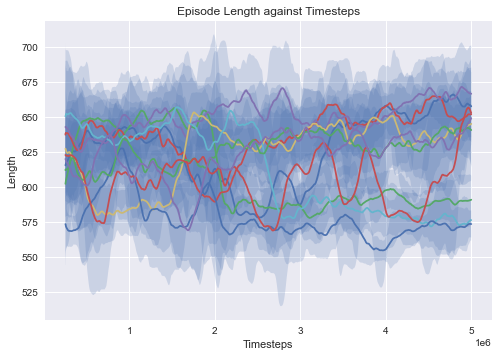

No handles with labels found to put in legend.


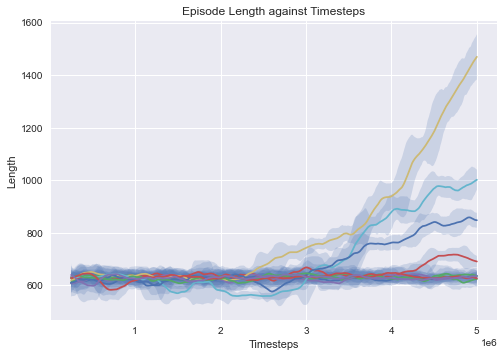

No handles with labels found to put in legend.


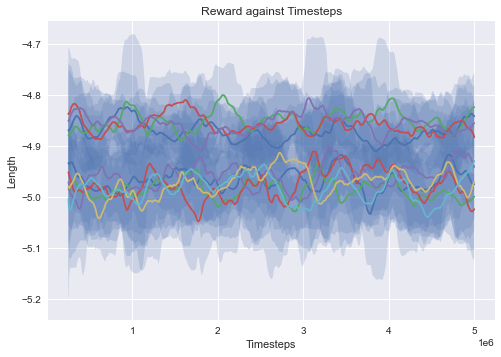

No handles with labels found to put in legend.


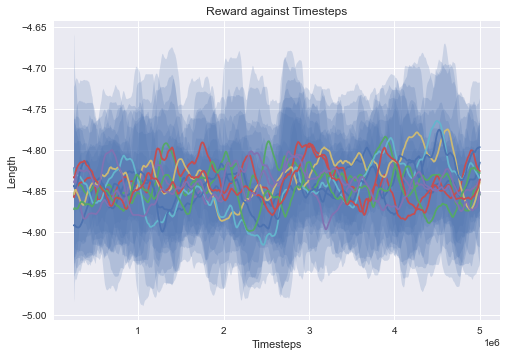

In [58]:
list_df_ppo_dnn_expert = [read_progress(f'ppo-dnn/{i}', 'expert') for i in range(1, 11)]
list_df_ppo_bnn_expert = [read_progress(f'ppo-bnn/{i}', 'expert') for i in range(1, 11)]

compare_eplen(list_df_ppo_dnn_expert, None)
compare_eplen(list_df_ppo_bnn_expert, None)

compare_eprew(list_df_ppo_dnn_expert, None)
compare_eprew(list_df_ppo_bnn_expert, None)

# Expert: PPO

## 3. Training Stability

In [59]:
get_rew_var(list_df_ppo_dnn_expert[0], list_df_ppo_bnn_expert[0], 'PPO-DNN', 'PPO-BNN', last_n=100_000)

Reward Variance of Last 100K: PPO-DNN=0.003, PPO-BNN=0.002


# Expert: PPO

## 4. Uncertainty

C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


When velocity exceeds 99th percentile, entropy of PPO-DNN=0.929, PPO-BNN=1.068


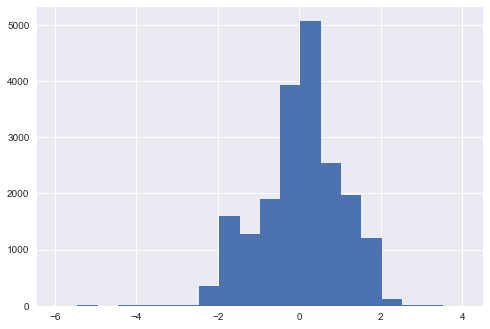

When velocity exceeds 99th percentile, entropy of PPO-DNN=0.842, PPO-BNN=0.978


In [60]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")
ppo_dnn_bnn_dataset_expert = get_datasets(env, ppo_dnn_expert, ppo_bnn_expert, trials=100)
ppo_dnn_bnn_dataset_expert.to_csv("ppo_dnn_bnn_dataset_expert.csv", index=False)

get_entropy_near_net(ppo_dnn_bnn_dataset_expert, 'PPO-DNN', 'PPO-BNN')
get_entropy_high_velocity(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN')

# Expert: PPO

## 5. Generalisability

In [61]:
dnn_score, bnn_score, dnn_var, bnn_var = evaluate(ppo_dnn_expert, ppo_bnn_expert, n=10)

C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]

Player 1: 1.4 +- 2.871
Player 2: -1.4 +- 2.871


# Expert: PPO

## 6. Agent Behaviour

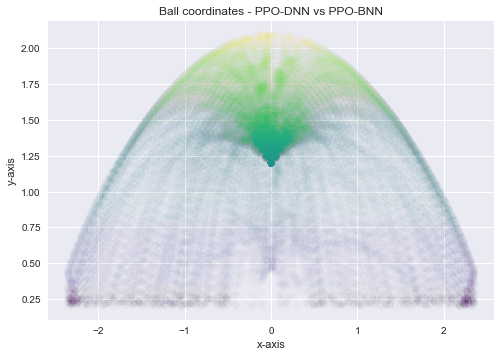

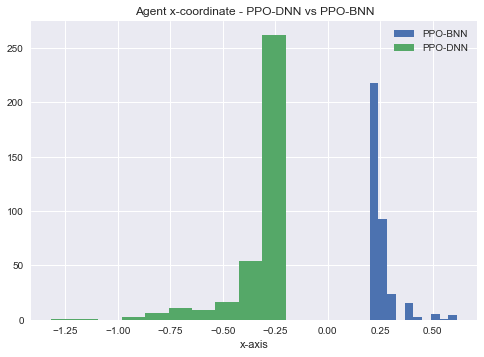

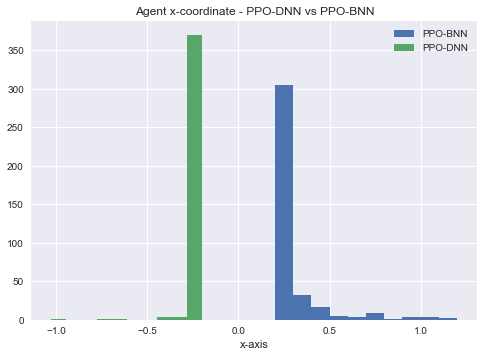

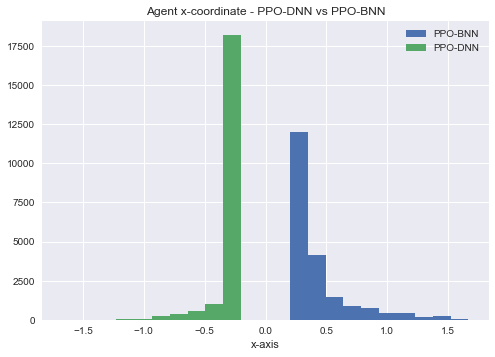

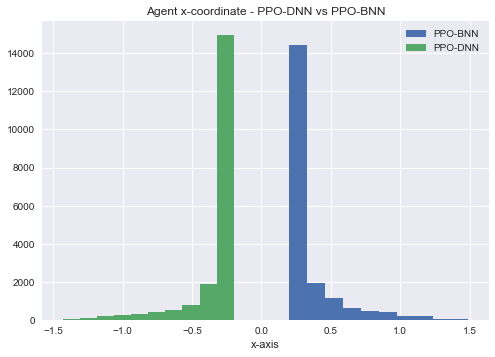

In [62]:
plot_ball_coordinates(ppo_dnn_bnn_dataset_expert, "PPO-DNN", "PPO-BNN", alpha=0.007)

plot_agent_coordinates(ppo_dnn_bnn_dataset_expert, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_expert, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

plot_agent_coordinates(ppo_dnn_bnn_dataset_expert, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_expert, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)

# Self: PPO

## 1. Performance

In [46]:
ppo_dnn_self = PPO1.load(os.path.join("exp/self/ppo-dnn", "final_model"))
ppo_bnn_self = PPO1.load(os.path.join("exp/self/ppo-bnn", "final_model"))

ppo_dnn_self_mujoco = PPO1.load(os.path.join("exp/self/ppo-dnn-mujoco", "final_model"))
# ppo_bnn_self_mujoco = PPO1.load(os.path.join("exp/self/ppo-bnn-mujoco", "final_model"))

# Evaluate DNN vs BNN
_, _, _, _ = evaluate(ppo_dnn_self, ppo_bnn_self, n=10)

# Evaluate DNN vs DNN-M  & BNN vs DNN-M
_, _, _, _ = evaluate(ppo_dnn_self, ppo_dnn_self_mujoco, n=10)
_, _, _, _ = evaluate(ppo_bnn_self, ppo_dnn_self_mujoco, n=10)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Player 1: -3.9 +- 1.221
Player 2: 3.9 +- 1.221


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Player 1: -4.9 +- 0.300
Player 2: 4.9 +- 0.300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.07s/it]

Player 1: -0.5 +- 0.806
Player 2: 0.5 +- 0.806


# Self: PPO

## 2. Sample Efficiency

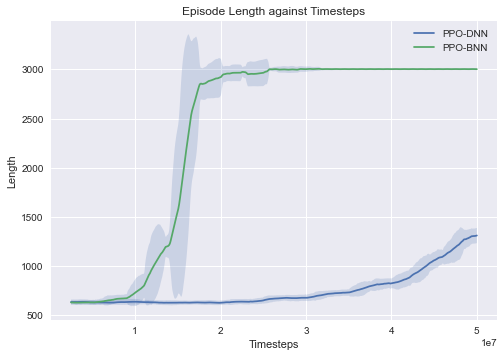

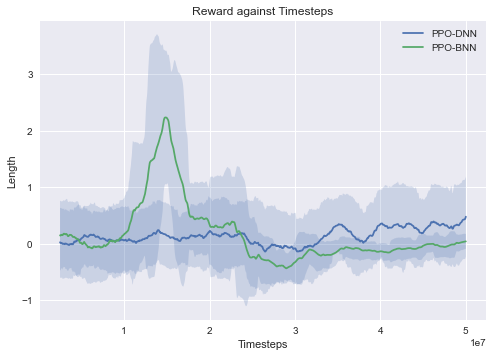

In [49]:
df_ppo_dnn_self = read_progress('ppo-dnn', 'self')
df_ppo_bnn_self = read_progress('ppo-bnn', 'self')

df_ppo_dnn_self_mujoco = read_progress('ppo-dnn-mujoco', 'self')
# df_ppo_bnn_self_mujoco = read_progress('ppo-bnn-mujoco', 'self')

compare_eplen([df_ppo_dnn_self, df_ppo_bnn_self], ['PPO-DNN', 'PPO-BNN'])
compare_eprew([df_ppo_dnn_self, df_ppo_bnn_self], ['PPO-DNN', 'PPO-BNN'])

# compare_eplen([df_ppo_dnn_self_mujoco, df_ppo_dnn_self_mujoco], ['PPO-DNN', 'PPO-BNN'])
# compare_eprew([df_ppo_dnn_self_mujoco, df_ppo_dnn_self_mujoco], ['PPO-DNN', 'PPO-BNN'])

# Self: PPO
## 3. Training Stability

In [63]:
get_rew_var(df_ppo_dnn_self, df_ppo_bnn_self, 'PPO-DNN', 'PPO-BNN', last_n=100_000)
# get_rew_var(df_ppo_dnn_self_mujoco, df_ppo_bnn_self_mujoco, 'PPO-DNN', 'PPO-BNN', last_n=100_000)

Reward Variance of Last 100K: PPO-DNN=0.138, PPO-BNN=0.029


# Self: PPO

## 4. Uncertainty

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


When velocity exceeds 99th percentile, entropy of PPO-DNN=0.821, PPO-BNN=1.021


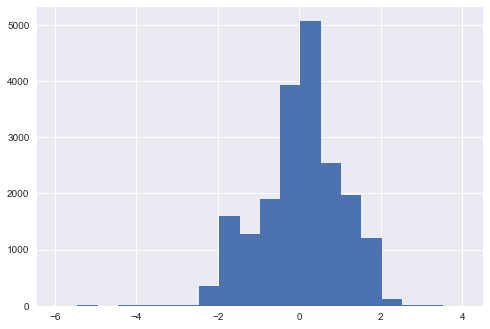

When velocity exceeds 99th percentile, entropy of PPO-DNN=0.842, PPO-BNN=0.978


In [32]:
env = gym.make("SlimeVolley-v0")

ppo_dnn_bnn_dataset_self = get_datasets(env, ppo_dnn_self, ppo_bnn_self, trials=10)
ppo_dnn_bnn_dataset_self.to_csv("ppo_dnn_bnn_dataset_self.csv", index=False)

# ppo_dnn_bnn_dataset_self_mujoco = get_datasets(env, ppo_dnn_self_mujoco, ppo_bnn_self_mujoco, trials=10)
# ppo_dnn_bnn_dataset_self_mujoco.to_csv("ppo_dnn_bnn_dataset_self_mujoco.csv", index=False)

get_entropy_near_net(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN')
get_entropy_high_velocity(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN')

# get_entropy_near_net(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN')
# get_entropy_high_velocity(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN')

# Self: PPO

## 5. Generalisability

In [55]:
score, var = evaluate_single(ppo_dnn_self, n=10)
score, var = evaluate_single(ppo_bnn_self, n=10)

score, var = evaluate_single(ppo_dnn_self_mujoco, n=10)
# score, var = evaluate_single(ppo_bnn_self_mujoco, n=10)

C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Player 1: -4.7 +- 0.640


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Player 1: 0.0 +- 0.447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]

Player 1: 0.3 +- 0.458


# Self: PPO

## 6. Agent Behaviour

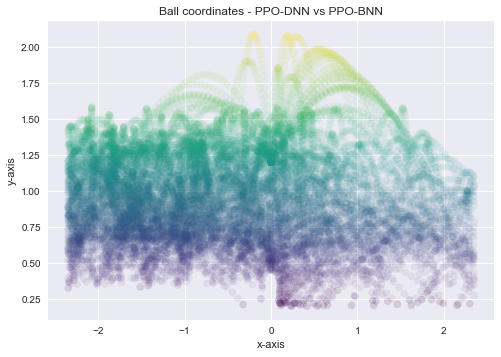

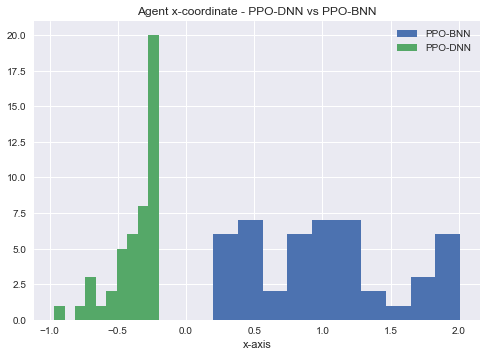

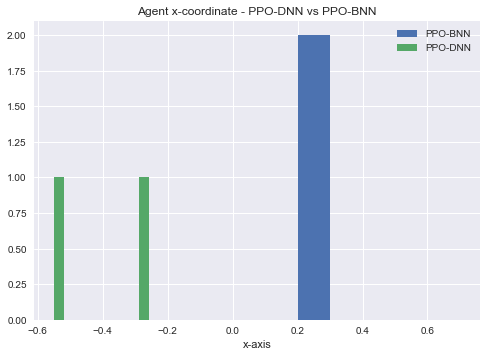

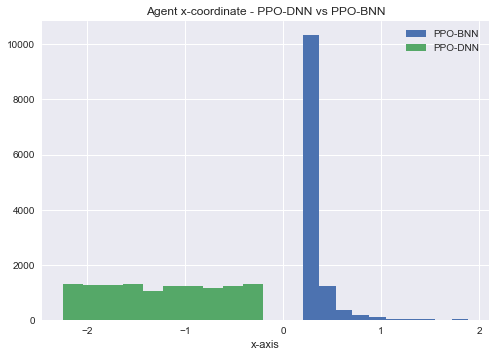

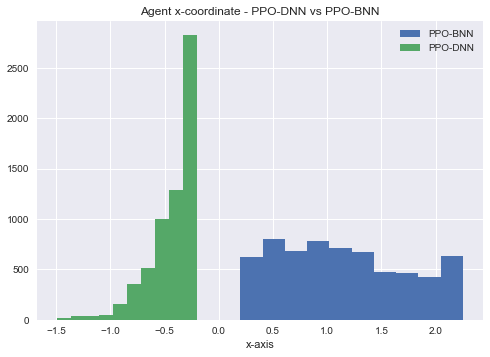

In [64]:
plot_ball_coordinates(ppo_dnn_bnn_dataset_self, "PPO-DNN", "PPO-BNN", alpha=0.07)

plot_agent_coordinates(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

plot_agent_coordinates(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_self, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)


# plot_ball_coordinates(ppo_dnn_bnn_dataset_self_mujoco, "PPO-DNN", "PPO-BNN", alpha=0.007)

# plot_agent_coordinates(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
# plot_agent_coordinates(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

# plot_agent_coordinates(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
# plot_agent_coordinates(ppo_dnn_bnn_dataset_self_mujoco, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)

# Multi: PPO

## 1. Performance

In [56]:
ppo_dnn_multi = PPO1.load(os.path.join("exp/multi/ppo-dnn", "final_model"))
ppo_bnn_multi = PPO1.load(os.path.join("exp/multi/ppo-bnn", "final_model"))

# ppo_dnn_multi_mujoco = PPO1.load(os.path.join("exp/multi/ppo-dnn-mujoco", "final_model"))
# ppo_bnn_multi_mujoco = PPO1.load(os.path.join("exp/multi/ppo-bnn-mujoco", "final_model"))

_, _, _, _ = evaluate(ppo_dnn_multi, ppo_bnn_multi, n=10)
# _, _, _, _ = evaluate(ppo_dnn_multi_mujoco, ppo_bnn_multi_mujoco, n=10)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]

Player 1: -0.8 +- 2.561
Player 2: 0.8 +- 2.561


# Multi: PPO

## 2. Sample Efficiency

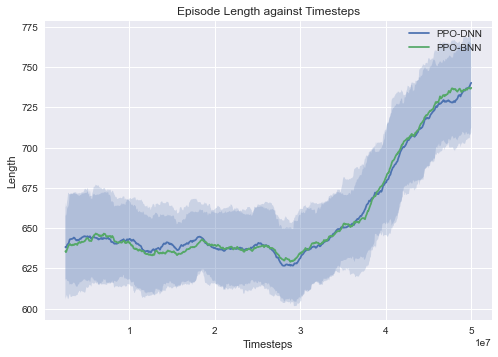

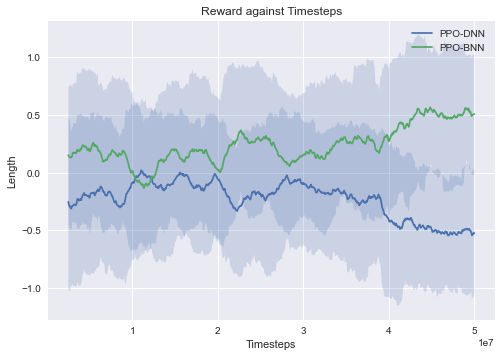

In [35]:
df_ppo_dnn_multi = read_progress('ppo-dnn', 'multi')
df_ppo_bnn_multi = read_progress('ppo-bnn', 'multi')

# df_ppo_dnn_multi_mujoco = read_progress('ppo-dnn-mujoco', 'multi')
# df_ppo_bnn_multi_mujoco = read_progress('ppo-bnn-mujoco', 'multi')

compare_eplen([df_ppo_dnn_multi, df_ppo_bnn_multi], ['PPO-DNN', 'PPO-BNN'])
compare_eprew([df_ppo_dnn_multi, df_ppo_bnn_multi], ['PPO-DNN', 'PPO-BNN'])

# compare_eplen([df_ppo_dnn_multi_mujoco, df_ppo_bnn_multi_mujoco], ['PPO-DNN', 'PPO-BNN'])
# compare_eprew([df_ppo_dnn_multi_mujoco, df_ppo_bnn_multi_mujoco], ['PPO-DNN', 'PPO-BNN'])

# Multi: PPO

## 3. Training Stability

In [36]:
get_rew_var(df_ppo_dnn_multi, df_ppo_bnn_multi, 'PPO-DNN', 'PPO-BNN', last_n=100_000)
get_rew_var(df_ppo_dnn_multi_mujoco, df_ppo_bnn_multi_mujoco, 'PPO-DNN', 'PPO-BNN', last_n=100_000)

Reward Variance of Last 100K: PPO-DNN=0.113, PPO-BNN=0.112


# Multi: PPO

## 4. Uncertainty

C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


When velocity exceeds 99th percentile, entropy of PPO-DNN=0.961, PPO-BNN=0.986


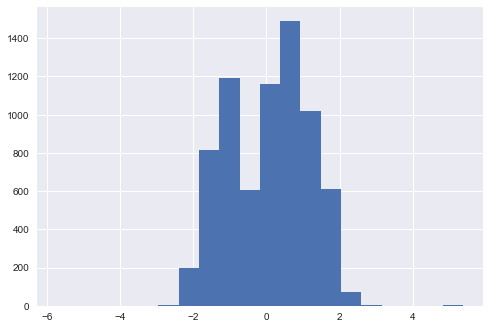

When velocity exceeds 99th percentile, entropy of PPO-DNN=1.004, PPO-BNN=1.058


In [37]:
env = gym.make("SlimeVolley-v0")

ppo_dnn_bnn_dataset_multi = get_datasets(env, ppo_dnn_multi, ppo_bnn_multi, trials=10)
ppo_dnn_bnn_dataset_multi.to_csv("ppo_dnn_bnn_dataset_multi.csv", index=False)

get_entropy_near_net(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN')
get_entropy_high_velocity(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN')


# env = gym.make("SlimeVolley-v0")

# ppo_dnn_bnn_dataset_multi_mujoco = get_datasets(env, ppo_dnn_multi_mujoco, ppo_bnn_multi_mujoco, trials=10)
# ppo_dnn_bnn_dataset_multi_mujoco.to_csv("ppo_dnn_bnn_dataset_multi_mujoco.csv", index=False)

# get_entropy_near_net(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN')
# get_entropy_high_velocity(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN')

# Multi: PPO

## 5. Generalisability

# Multi: PPO

## 6. Agent Behaviour

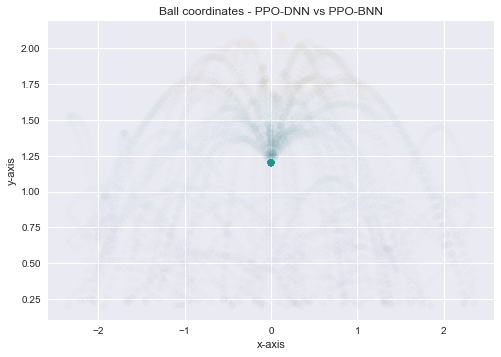

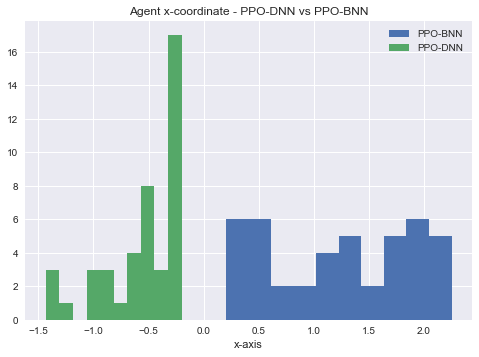

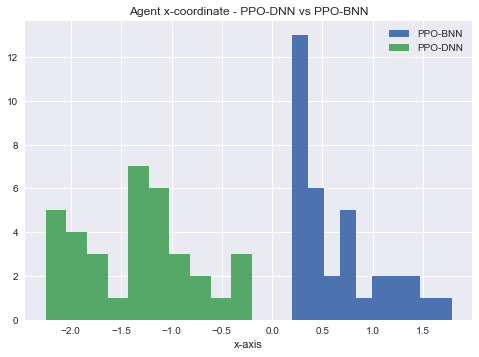

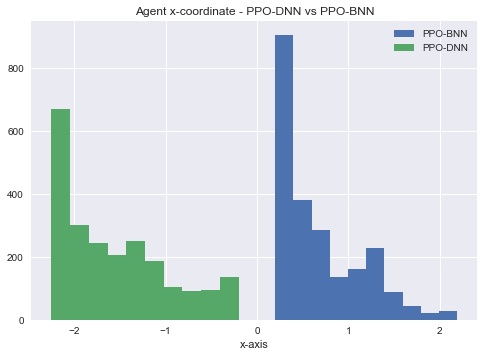

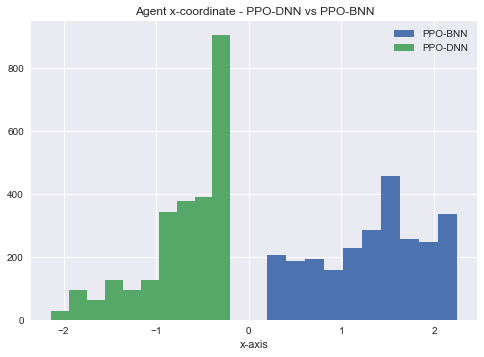

In [38]:
plot_ball_coordinates(ppo_dnn_bnn_dataset_multi, "PPO-DNN", "PPO-BNN", alpha=0.007)

plot_agent_coordinates(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

plot_agent_coordinates(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_dataset_multi, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)


# plot_ball_coordinates(ppo_dnn_bnn_dataset_multi_mujoco, "PPO-DNN", "PPO-BNN", alpha=0.007)

# plot_agent_coordinates(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
# plot_agent_coordinates(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

# plot_agent_coordinates(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
# plot_agent_coordinates(ppo_dnn_bnn_dataset_multi_mujoco, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)